(DEMetropolisZ_sampler_tuning)=
# DEMetropolis(Z) Sampler Tuning
:::{post} January 18, 2023
:tags: DEMetropolis(Z), gradient-free inference
:category: intermediate, how-to
:author: Michael Osthege, Greg Brunkhorst
:::

In [1]:
import time

import arviz as az

az.rcParams["plot.max_subplots"] = 100
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from matplotlib import cm, gridspec

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v0+untagged.9358.g8ea092d


In [2]:
%load_ext watermark
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

## Background
For continuous variables, the default PyMC sampler (`NUTS`) requires that gradients are computed, which PyMC does through autodifferentiation.  However, in some cases, a PyMC model may not be supplied with gradients (for example, by evaluating a numerical model outside of PyMC) and an alternative sampler is necessary.  The `DEMetropolisZ` sampler is an efficient choice for gradient-free inference.  The implementation of `DEMetropolisZ` in PyMC is based on {cite:t}`terBraak2008differential` but with a modified tuning scheme.  This notebook compares various tuning parameter settings for the sampler, including the `drop_tune_fraction` parameter which was introduced in PyMC.    

## Key Take-Away (TL;DR)
The `DEMetropolisZ` sampler implementation in PyMC has sensible defaults; however, two manual adjustments improved sampler performance in this notebook: setting `tuning` to "scaling", and setting `proposal_dist` to `pm.NormalProposal`.  In the simplest form, the manual adjustments look like the following:

    with model:
        step = pm.DEMetropolisZ(
            tune='scaling', 
            proposal_dist=pm.NormalProposal
        )
        idata = pm.sample(step=step)

## Sampler Approach
The different flavors of the Metropolis algorithm for continuous variables in PyMC have different methods for deciding how far and in which direction to make jumps.  The vanilla `pm.Metropolis` sampler performs a tuning process to scale the size of the jumps.  Each jump is then a random draw from a proposal distribution times the tuned scaling factor.

The differential evolution (DE) Metropolis algorithms use randomly selected draws from other chains (DEMetropolis) or from past draws of the current chain (DEMetropolis(Z)) to make more educated jumps.  Here is the formula for making jumps for the DEMetropolis algorithms using the nomenclature in {cite:t}`terBraak2008differential`:

### Differential Evolution Jump Equation
$$x^*=x_i + \gamma(x_{R1}-x_{R2}) + \epsilon$$ 
where:  
* $x^*=$ proposal  
* $x_i=$ current state (sample)  
* $\gamma=$ factor that determines the size of the jump relative to a random vector.  This is referred to as `lamb` in the PyMC implementation and is tuned by default (with a starting value of ${2.38}/{\sqrt{2d}}$ where $d=$ the number of dimensions [i.e., parameters]).    
* $(x_{R1}-x_{R2})=$ a random vector based on the subtraction of two randomly selected past states (samples).  DEMetropolis selects from other chains and DEMetropolis(Z) selects from past draws of the current chain.      
* $\epsilon=$ additional noise that is added to each move:  
  
$$\epsilon \sim \mathscr{D}_{p}(A)\cdot b$$  

where:   
* $\mathscr{D}_{p}(A)=$ a proposal distribution centered on zero with a variance term of A (defaults to a Uniform proposal with A=1 [i.e., -1 to 1] in PyMC).    
* $b=$ scaling factor.  This is `scaling` in PyMC and can be tuned (defaults to 0.001).

In PyMC, we can tune either `lamb` ($\gamma$), or `scaling` ($b$), and the other parameter is fixed.

## Problem Statement
In this notebook, a 10-dimensional multivariate normal target density will be sampled with `DEMetropolisZ` while varing four parameters to identify efficient sampling schemes.  The four parameters are the following:
* `drop_tuning_fraction`, which determines the number of samples from the tuning phase that are recycled for the purpose of random vector $(x_{R1}-x_{R2})$ selection,  
* `lamb` ($\gamma$), which scales the size of the jumps relative to the random vector, 
* `scaling` ($b$), which scales the size of the jumps for the noise term $\epsilon$, and 
* `proposal_distribution` ($\mathscr{D}_{p}$), which determines the shape from which to draw $\epsilon$.

We will evaluate these sampling parameters based on three sampling metrics: effective sample size, autocorrelation, and sample acceptance rates.

## Target Distribution
We use a multivariate normal target density with some correlation in the first few dimensions.  The function `gen_mvnormal_params` generates the parameters for the target distribution.

In [3]:
def gen_mvnormal_params(D):
    # means=zero
    mu = np.zeros(D)
    # sigmas=1 to start
    cov = np.eye(D)
    # add variance and covariance in the first 5 dimensions
    cov[:5, :5] = np.array(
        [
            [1, 0.5, 0, 0, 0],
            [0.5, 2, 2, 0, 0],
            [0, 2, 3, 0, 0],
            [0, 0, 0, 4, 4],
            [0, 0, 0, 4, 5],
        ]
    )
    return mu, cov

The function `make_model_sample` accepts the multivariate normal parameters `mu` and `cov` and outputs a PyMC model and a random sample of the target distribution.

In [4]:
def make_model_sample(mu, cov, draws=1000):
    with pm.Model() as model:
        x = pm.MvNormal("x", mu=mu, cov=cov, shape=(len(mu),))

    target_sample = pm.draw(x, draws=draws)
    target_idata = az.data.convert_to_inference_data(target_sample[np.newaxis, :], group="target")
    return model, target_idata

The example will be 10-dimensional

In [5]:
D = 10
mu, cov = gen_mvnormal_params(D)
model, target_idata = make_model_sample(mu, cov)

c:\Users\greg\.conda\envs\pymc-dev\Lib\site-packages\arviz\data\inference_data.py:153: UserWarning: target group is not defined in the InferenceData scheme
  warnings.warn(


It is handy to have a picture of the distribution in our minds.

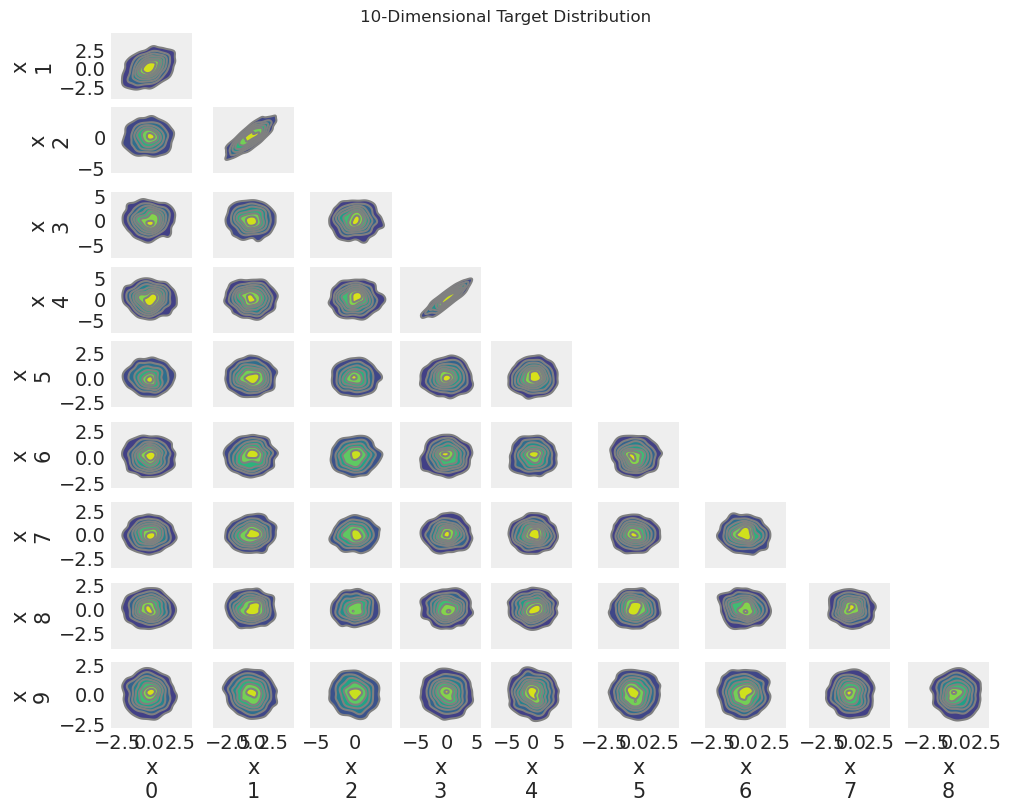

In [6]:
az.plot_pair(target_idata.target, kind="kde", figsize=(10, 8))
plt.suptitle("10-Dimensional Target Distribution");

## Helper Functions
We will define a number of helper functions upfront to reuse throughout the notebook.

### Sampling
`sample_model` performs MCMC, returns the trace and the sampling duration.

In [7]:
def sample_model(model, run=0, step_kwargs={}, sample_kwargs={}):
    with model:
        step = pm.DEMetropolisZ(**step_kwargs)
        t_start = time.time()
        idata = pm.sample(
            step=step,
            chains=1,
            initvals={"x": [7.0] * D},
            discard_tuned_samples=False,
            progressbar=False,
            random_seed=2020 + run,
            **sample_kwargs
        )
        t = time.time() - t_start
    return idata, t

### MCMC Metrics
To evaluate the MCMC samples, we will use three different metrics.  
* **Effective sample size (ESS)** is the sample size adjusted for autocorrelation in the trace.  The ESS will be expressed as a percentage ${(ESS)}/{(\text{Total Draws})}*100$.  A higher ESS is better.  For a Metropolis sampler, 2% ESS is fairly high. 
* **Autocorrelation** in the trace is a sign of sampler inefficiency, and should be close to zero.  The autocorrelation at sample 100 (after tuning) will be used for comparison.  
* **Acceptance rate** of sample draws should be roughly flat over the course of the trace.  Decreasing acceptance rates indicate that the step size started off too small, and increasing acceptance rate indicate that the step size started off too large.

`calc_ess_pct` calculates ${(ESS)}/{(\text{Total Draws})}*100$.

In [8]:
def calc_ess_pct(idata, chains=1):
    draws = idata.posterior.draw.shape[0] * chains
    ess = az.ess(idata).x.values
    return ess * 100 / draws

`calc_autocorr` calculates the autocorrelation for the trace after a specified number of samples.

In [9]:
def calc_autocorr(idata, sample=100):
    return az.autocorr(az.extract(idata).x.values)[:, sample]

`calc_acceptance` calculates the slope and intercept of the acceptance rate for the trace.

In [10]:
def calc_acceptance(idata, window=500):
    rolling_rate = (
        pd.Series(idata.sample_stats.accepted.values.flatten()).rolling(window=window).mean().values
    )

    x = np.arange(0, len(rolling_rate))
    A = np.vstack([x, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A[window - 1 :, :], rolling_rate[window - 1 :], rcond=None)[
        0
    ]

    return slope, intercept, rolling_rate

### Repeated Sampling and Calculations

`sample_model_calc_metrics` samples the model iteratively for different parameter values, calculates the metrics for each trace, and returns a dataframe with the results.

In [11]:
def sample_model_calc_metrics(
    model,
    param="tune_drop_fraction",
    param_values=[0, 0.5, 0.9, 1.0],
    step_kwargs={},
    sample_kwargs={},
    N_tune=10000,
    N_draws=10000,
    N_runs=5,
    window=500,
):
    cols = (param + ",run,ess_pct,autocorr100,accept_slope,time,idata").split(",")
    idx = (param + ",run").split(",")
    df_results = pd.DataFrame(columns=cols).set_index(idx)
    idatas = []
    for param_value in param_values:
        for r in range(N_runs):
            all_step_kwargs = dict(step_kwargs, **{param: param_value})
            idata, t = sample_model(
                model,
                run=r,
                step_kwargs=all_step_kwargs,
                sample_kwargs=dict(sample_kwargs, **dict(tune=N_tune, draws=N_draws)),
            )
            if type(param_value) == type:
                index_name = param_value.__name__[:-8]
            else:
                index_name = param_value
            df_results.loc[(index_name, r), "ess_pct"] = calc_ess_pct(idata).mean()
            df_results.loc[(index_name, r), "autocorr100"] = calc_autocorr(idata).mean()
            slope, _, _ = calc_acceptance(idata, window=window)
            df_results.loc[(index_name, r), "accept_slope"] = slope
            df_results.loc[(index_name, r), "time"] = t
            idatas.append(idata)
    df_results.idata = idatas
    num_cols = ["ess_pct", "autocorr100", "accept_slope", "time"]
    for num_col in num_cols:
        df_results[num_col] = pd.to_numeric(df_results[num_col])
    return df_results

`average_results` takes the large results dataframe and averages replicate runs.

In [12]:
def average_results(df_results, param="tune_drop_fraction"):
    return df_results.reset_index().groupby(param).mean(numeric_only=True).drop(columns=["run"])

### Plotting

`plot_metric_results` plots 2x2 summary of results for multiple inferences.

In [13]:
def plot_metric_results(
    df_results,
    param="tune_drop_fraction",
    titles=dict(
        ess_pct="Effective Sample Size\n(% of Total Samples)",
        autocorr100="Autocorrelation\n(Samples 0 to 100)",
        accept_slope="Trend in Fraction Accepted\nDuring Sampling",
        time="Duration of Sampling\n(seconds)",
    ),
):
    plot_df = average_results(df_results.iloc[:, :-1], param=param)
    cols = plot_df.columns
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    for col, ax in zip(cols, axes.flatten()):
        ax.plot(plot_df.index, plot_df[col], "o-")
        ax.set_title(titles[col], weight="bold")
        if col == "accept_slope":
            if plot_df[col].max() < 0:
                ax.set_ylim(top=0)
        elif col == "autocorr100":
            if plot_df[col].min() > 0:
                ax.set_ylim(0)
            # else don't mess with the  ylim
        else:
            ax.set_ylim(0)
        ax.set_xlabel(param)
    plt.suptitle(param + " Results", fontsize=20)
    plt.tight_layout()
    return axes

`plot_ess_trace_drop_tune_fraction` plots the effective sample size and the traces for various tune_drop_fractions.

In [14]:
def plot_ess_trace_drop_tune_fraction(df_results):
    df_temp = df_results.ess_pct.unstack("run").T

    fig = plt.figure(dpi=100, figsize=(12, 8))
    gs = gridspec.GridSpec(4, 2, figure=fig, width_ratios=[1, 2])
    ax_left = plt.subplot(gs[:, 0])
    ax_right_bottom = plt.subplot(gs[3, 1])
    axs_right = [
        plt.subplot(gs[0, 1], sharex=ax_right_bottom),
        plt.subplot(gs[1, 1], sharex=ax_right_bottom),
        plt.subplot(gs[2, 1], sharex=ax_right_bottom),
        ax_right_bottom,
    ]
    for ax in axs_right[:-1]:
        plt.setp(ax.get_xticklabels(), visible=False)

    # ess plot
    ax_left.bar(
        x=df_temp.columns,
        height=df_temp.mean(),
        width=0.05,
        alpha=0,
        yerr=df_temp.sem(),
    )
    ax_left.set_xlabel("tune_drop_fraction")
    ax_left.set_ylabel("$ESS$   [%]")
    ax_left.plot(df_temp.columns, df_temp.mean(), ":")

    # traceplots
    notes = [
        "Wide variance in the chain after tuning",
        "",
        "",
        "Bottleneck of reduced variance after tuning",
    ]
    for ax, drop_fraction, note in zip(axs_right, df_temp.columns, notes):
        ax.set_ylabel("$f_{drop}$=" + f"{drop_fraction}")
        for r, idata in enumerate(df_results.loc[(drop_fraction)].idata):
            # combine warmup and draw iterations into one array:
            samples = np.vstack(
                [
                    idata.warmup_posterior.x.sel(chain=0).values,
                    idata.posterior.x.sel(chain=0).values,
                ]
            )
            ax.plot(samples, linewidth=0.25)
        ax.axvline(N_tune, linestyle="--", linewidth=0.5, label="End of Tuning")
        ax.text(10100, -12, note)
    axs_right[0].legend(loc="upper right")

    axs_right[0].set_title(f"Traces")
    ax_left.set_title("Effective Sample Size")
    ax_right_bottom.set_xlabel("Iteration")
    plt.suptitle("Tune_drop_fraction Effective Sample Size Results", fontsize=18)
    plt.tight_layout()

`plot_autocorr_drop_tune_fraction` plots the autocorrelation for the traces for various tune_drop_fractions.

In [15]:
def plot_autocorr_drop_tune_fraction(df_results, param_values=[0, 0.5, 0.9, 1]):
    fig, axs = plt.subplots(ncols=4, figsize=(10, 3), sharey="row")
    for ax, drop_fraction in zip(axs, param_values):
        az.plot_autocorr(df_results.loc[(drop_fraction, 0), "idata"].posterior.x.T, ax=ax)
        ax.set_title("$f_{drop}=$" + f"{drop_fraction}")
        ax.set_ylim(-0.1, 1)
        ax.set_ylim()
        ax.set_xlabel("Sample\n(Post-tuning)")
    axs[0].set_ylabel("Autocorrelation")
    plt.suptitle("Tune_drop_fraction Autocorrelation Results", fontsize=16)
    plt.tight_layout()

`plot_acceptance_rate_drop_tune_fraction` plots the acceptance rate for the traces for various tune_drop_fractions.

In [16]:
def plot_acceptance_rate_drop_tune_fraction(df_results):
    df_temp = df_results.ess_pct.unstack("run").T
    fig, ax = plt.subplots(ncols=1, figsize=(10, 6), sharey="row")

    for drop_fraction in df_temp.columns:
        # combine warmup and draw iterations into one array:
        idata = df_results.loc[(drop_fraction, 0), "idata"]
        S = np.hstack(
            [
                idata.warmup_sample_stats["accepted"].sel(chain=0),
                idata.sample_stats["accepted"].sel(chain=0),
            ]
        )
        for c in range(idata.posterior.dims["chain"]):
            ax.plot(
                pd.Series(S).rolling(window=500).mean().iloc[500 - 1 :].values,
                label="$f_{drop}$=" + f"{drop_fraction}",
            )
    ax.set_xlabel("Iteration")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    ax.axvline(N_tune, linestyle="--", linewidth=0.5)
    ax.text(N_tune + 100, 0.05, "End of Tuning")
    ax.set_ylabel("Rolling mean acceptance rate (w=500)")
    plt.ylim(0, 1)
    plt.suptitle("Tune_drop_fraction Acceptance Rate Results", fontsize=16)

## `Drop_tune_fraction`
Now we will compare different `drop_tune_fractions` and leave all other parameters as the defaults.

In [17]:
N_tune = N_draws = 10000
df_results = sample_model_calc_metrics(
    model,
    param="tune_drop_fraction",
    param_values=[0, 0.5, 0.9, 1.0],
    N_tune=N_tune,
    N_draws=N_draws,
)

Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequ

### Effective Sample Size
Here, the mean effective sample size is plotted with standard errors. Next to it, the traces of all chains in one dimension are shown to better understand why the effective sample sizes are different.  A larger effective sample size is better.

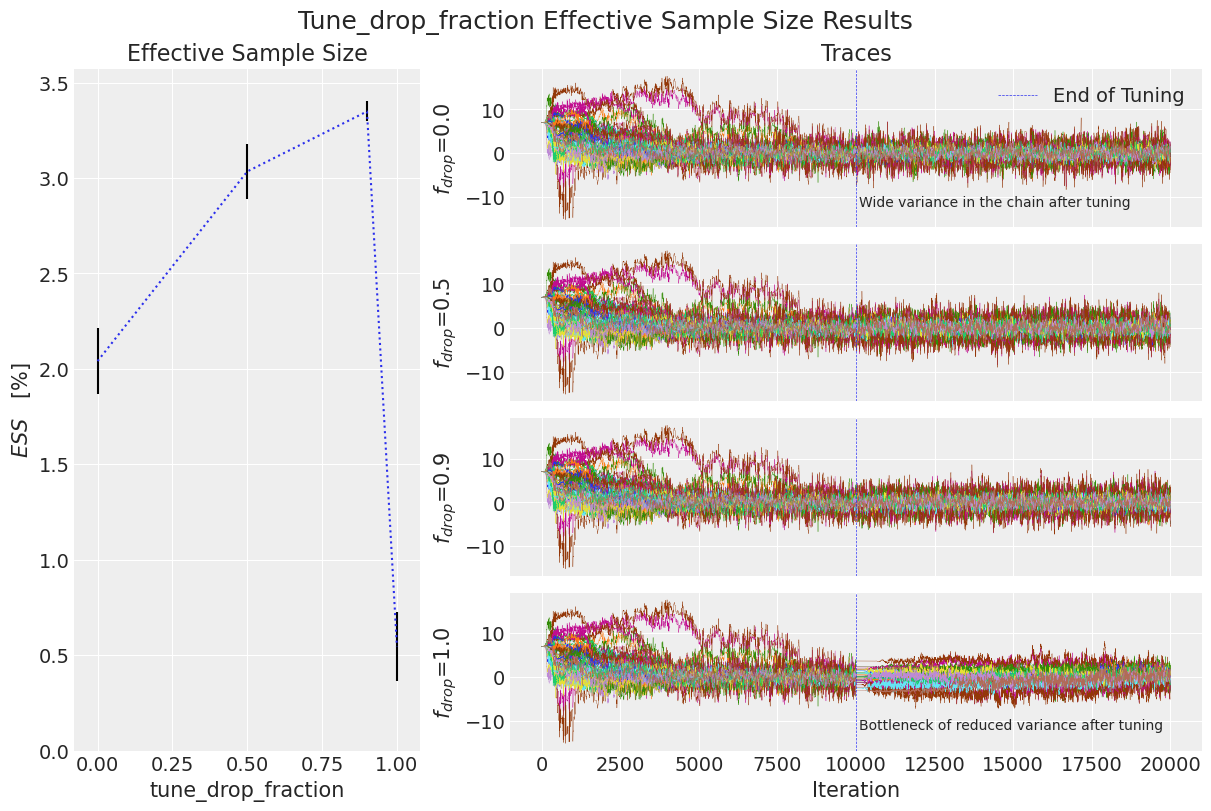

In [18]:
plot_ess_trace_drop_tune_fraction(df_results)

We can see that the ESS is higher for `drop_tune_fraction` equal to 0.5 or 0.9 compared to 0.0 or 1.0.  From looking at the traces, we see that the variance in the chains are wide after tuning when the `drop_tune_fraction` = 0.0.  At the other extreme, the chains go through a low-variance bottleneck when `drop_tune_fraction` = 1.0.

### Autocorrelation
A diagnostic measure for the effect we can see above is the autocorrelation in the sampling phase.  A lower autocorrelation is better.

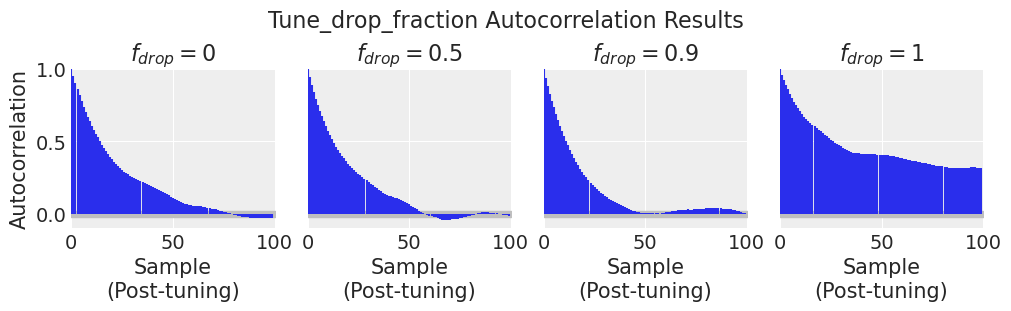

In [19]:
plot_autocorr_drop_tune_fraction(df_results)

By step 100, the autocorrelation for `drop_tune_fraction` = 0.9 has already declined near zero.  The autocorrelation remains higher for the other `drop_tune_fractions` either because sample steps are too large (`drop_tune_fraction` = 0.0), or too small (`drop_tune_fraction` = 1.0).  When the entire tuning history is dropped (`drop_tune_fraction` = 1.0), the chain has to diverge from its current position back into the typical set, which takes much longer.

### Acceptance Rate
The rolling mean over the `'accepted'` sampler stat shows the difference in the sampler performance for various `drop_tune_fractions`.  A downward trend in the acceptance rate after tuning indicates that the proposals are starting off too narrow, and an upward trend in the acceptance rate after tuning indicates that the proposals are starting off too wide.

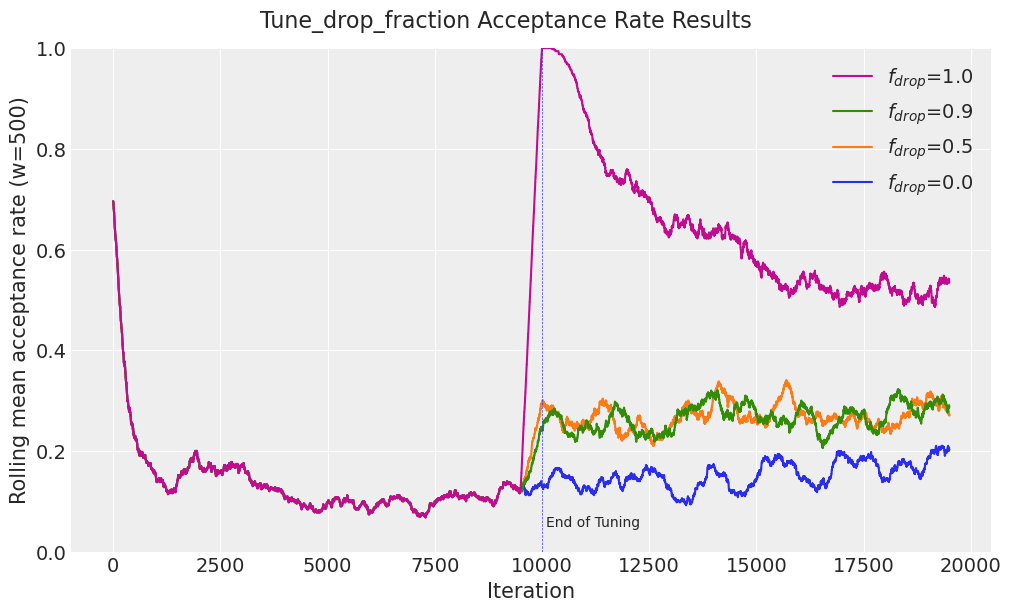

In [20]:
plot_acceptance_rate_drop_tune_fraction(df_results)

The trend in acceptance rate for `drop_tune_fraction` = 0.9 is approximately flat.  When the tuning history is dropped (`drop_tune_fraction` = 1.0), the acceptance rate shoots up to almost 100 %, because the proposals are too narrow.

### Summary

The results across all three metrics plus the duration of sampling are included below.

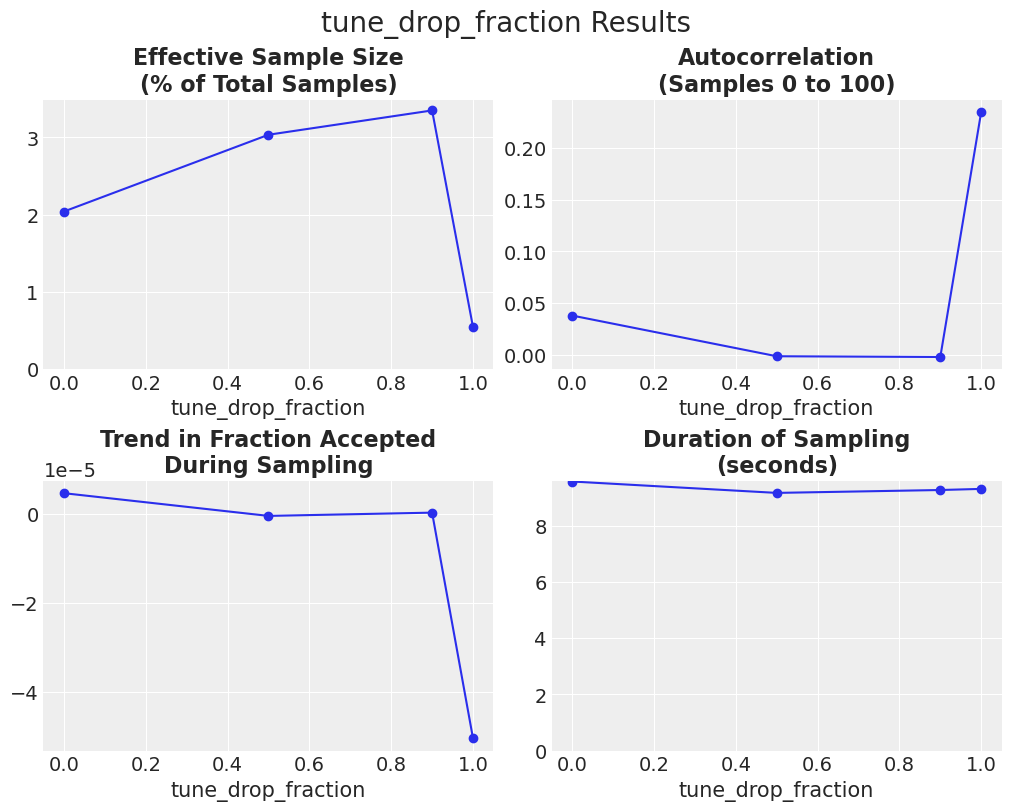

In [21]:
plot_metric_results(df_results);

## `Lamb`

`Lamb` is the factor that determines the size of the jump relative to a random vector and is tuned by default.  The starting value is ${2.38}/{\sqrt{2d}}$ where $d=$ the number of dimensions [i.e., parameters]).  We will vary `lamb` by one order of magnitude above and below the default and tune the `scaling` parameter to keep `lamb` fixed.

In [22]:
param = "lamb"
d = np.array([100, 20, 10, 5, 1])
lambs = 2.38 / np.sqrt(2 * d)
lambs

array([0.16829141, 0.37631104, 0.53218418, 0.75262208, 1.68291414])

In [23]:
df_results = sample_model_calc_metrics(
    model,
    param=param,
    param_values=lambs,
    step_kwargs=dict(tune="scaling"),
    N_tune=N_tune,
    N_draws=N_draws,
)

Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequ

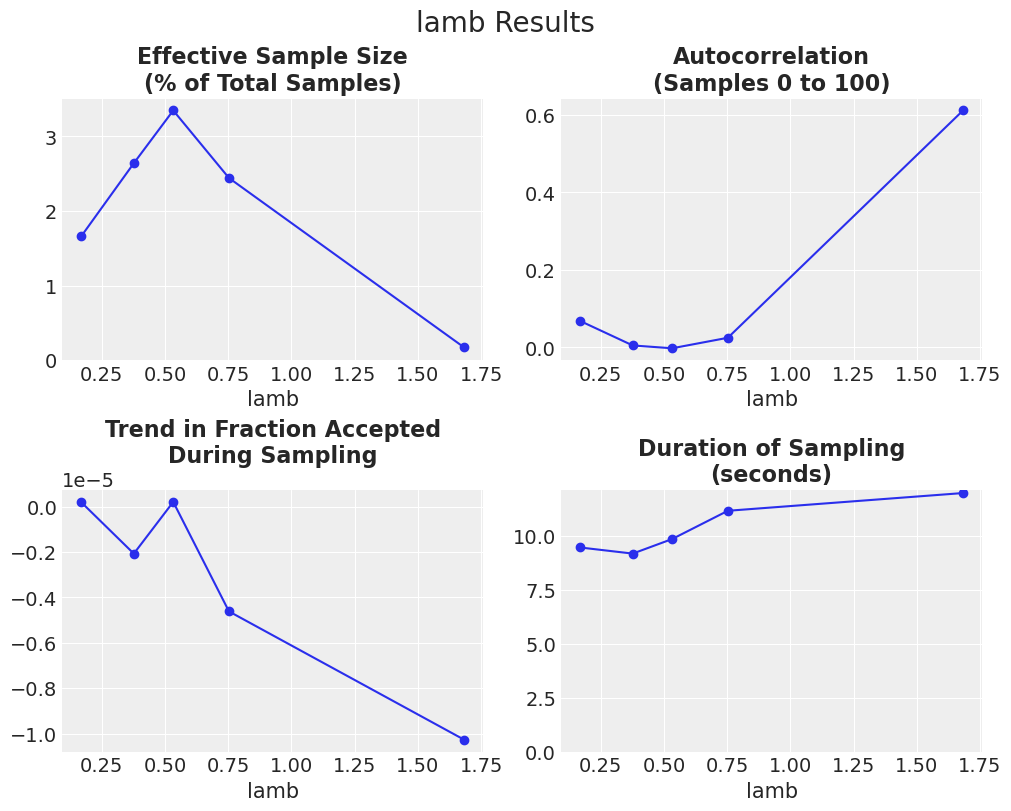

In [24]:
plot_metric_results(df_results, param=param);

The results show that the default starting value for `lamb` (about 0.5) is good.  Also note, these results can be compared to the results for `drop_tune_fraction` = 0.9 above, for which `lamb` was tuned, and `scaling` was specified as 0.001 (the defaults).  The ESS % was about 1.8 for that tuning set-up.  Therefore, these results indicate that fixing `lamb` and tuning `scaling` was better than fixing `scaling` and tuning `lamb` for this problem.  

In hindsight, this result makes sense because the random vector term (`lamb` * $(x_{R1}-x_{R2})$) is inherently scaled during sampling, because it draws from previous samples.  The noise term $\epsilon \sim \mathscr{D}_{p}(A)$* `scaling` is fixed during sampling, so it makes sense to tune `scaling` before sampling.

## `Scaling`

`scaling` determines the variance in the noise term and defaults to 0.001.  We will vary `scaling` by a total of 6 orders of magnitude and tune `lamb`.

In [25]:
scalings = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0.00001])
param = "scaling"

In [26]:
df_results = sample_model_calc_metrics(
    model,
    param="scaling",
    param_values=scalings,
    step_kwargs=dict(tune="lambda"),
    N_tune=N_tune,
    N_draws=N_draws,
)

Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
S

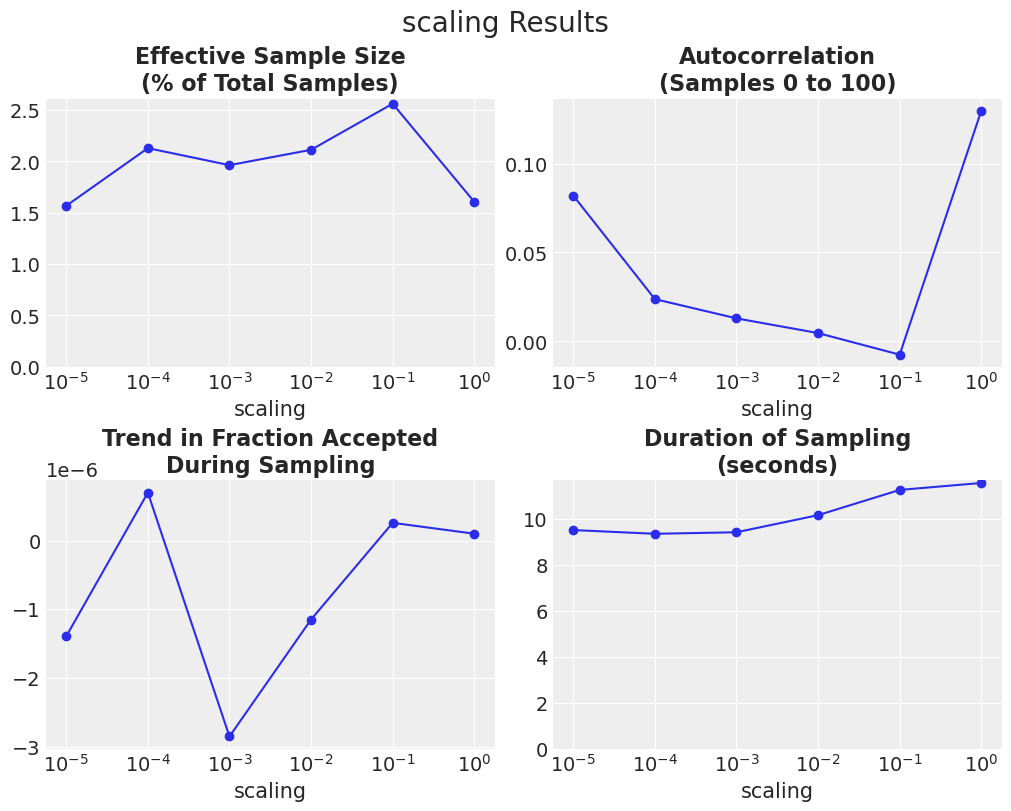

In [27]:
axes = plot_metric_results(df_results, param=param)
for ax in axes.flatten():
    ax.set_xscale("log")

Larger values of `lamb` performed better for this problem.  However, tuning `scaling` and fixing `lamb` (the previous experiment) performed better.

## `Proposal_distribution`

Finally, we can also vary the `proposal_distribution` ($\mathscr{D}_{p}$), which determines the shape from which to draw $\epsilon$.  PyMC provides four proposal distributions for use with continuous variables: Uniform (the default), Normal, Cauchy, and Laplace.  For this experiment, we will tune `scaling`, to allow each proposal distribution to be optimized, and keep `lamb` fixed.

In [28]:
param = "proposal_dist"
proposal_dists = [pm.UniformProposal, pm.NormalProposal, pm.CauchyProposal, pm.LaplaceProposal]

In [29]:
df_results = sample_model_calc_metrics(
    model,
    param=param,
    param_values=proposal_dists,
    step_kwargs=dict(tune="scaling"),
    N_tune=N_tune,
    N_draws=N_draws,
)

Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]
Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequ

C:\Users\greg\AppData\Local\Temp\ipykernel_16780\1850776206.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45)


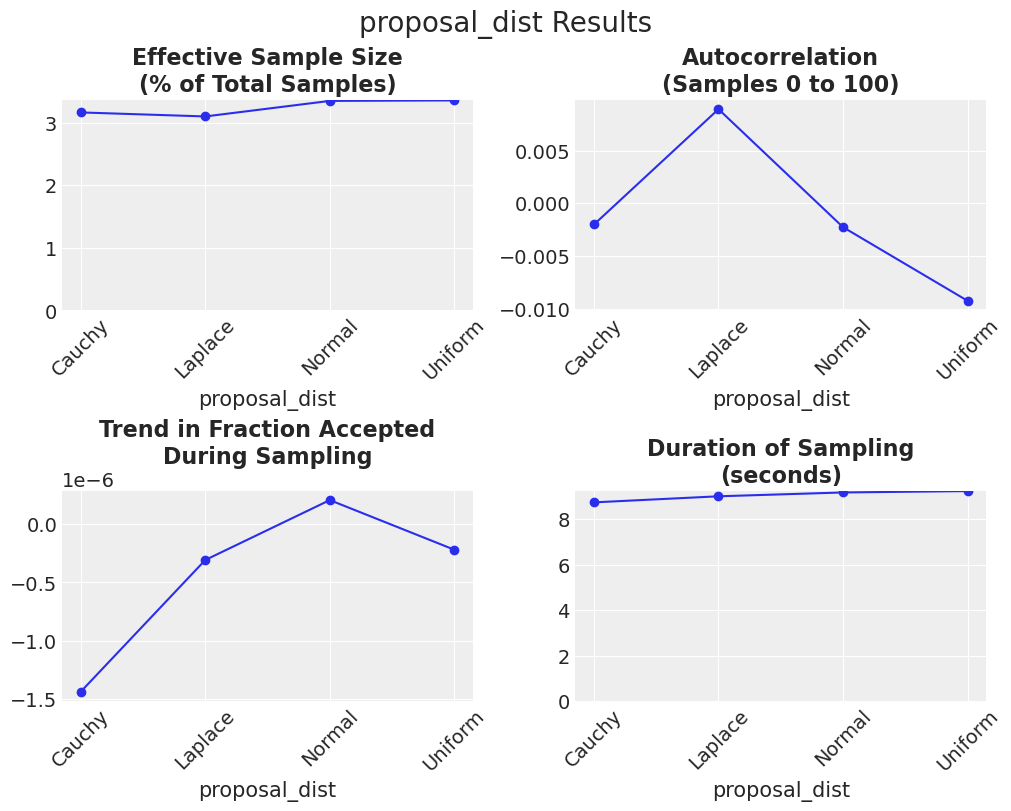

In [30]:
axes = plot_metric_results(df_results, param=param)
for ax in axes.flatten():
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, rotation=45)

All the distributions perform reasonably well.  The Normal and Uniform distributions appear to perform slightly better than the others, considering all three metrics.  Note that {cite:t}`terBraak2008differential` suggest that the `proposal_dist` should have unbounded support to maintain ergodicity, therefore the Normal distribution is preferred.

## Conclusions
Based on the experimentation above, the best performing sampling scheme for this distribution has two modifications to the default.  Here is what it looks like in a simplified form:

In [31]:
with model:
    step = pm.DEMetropolisZ(tune="scaling", proposal_dist=pm.NormalProposal)
    idata = pm.sample(step=step, chains=1, tune=N_tune, draws=N_draws)

Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [32]:
print("ESS % =", calc_ess_pct(idata).mean().round(1))

ESS % = 2.9


## Authors
Conceived by [Micheal Osthege](https://github.com/michaelosthege), expanded by [Greg Brunkhorst](https://github.com/gbrunkhorst).

## References

:::{bibliography}
:filter: docname in docnames
:::

In [33]:
%watermark -n -u -v -iv -w

Last updated: Fri Feb 10 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.7.0

arviz     : 0.14.0
sys       : 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:12:32) [MSC v.1929 64 bit (AMD64)]
numpy     : 1.24.0
pandas    : 1.5.2
matplotlib: 3.6.2
pymc      : 5.0.1+5.ga7f361bd

Watermark: 2.3.1



:::{include} ../page_footer.md
:::